In [1]:
import sys; sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os

import numpy  as np 
import xarray as xr

import matplotlib.pyplot  as plt
import GDa.graphics.plot  as plot
import matplotlib.patches as patches
import matplotlib

from   GDa.session           import session_info, session
from   GDa.signal.surrogates import trial_swap_surrogates

from xfrites.conn.conn_spec  import conn_spec

from tqdm import tqdm

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE=plot.set_plot_config()

#### Loading data

In [3]:
# Instantiate class
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '141017', session = 1,
              slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])

# Read data from .mat files
ses.read_from_mat()

# Filtering by trials
data = ses.filter_trials(trial_type=[1],behavioral_response=[1])

In [4]:
#### Surrogate data
n_surr    = 1
data_surr = []
for i in range(n_surr): data_surr += [trial_swap_surrogates(data, seed = i*500, verbose=False)]

#### Choosing pair of regions

These channel pairs display spectral peaks and strong coherence in Band 2. There are 2 short distance pairs (12-17, 17-18) and 1 long distance pair (17-181).

- 12 vs 17
- 17 vs 18
- 17 vs 181

These channel pairs display spectral peaks and strong coherence in Band 4. Both pairs are median distance examples.

- 69 vs 104
- 96 vs 106

In [5]:
channel_labels = np.array([12, 17, 18, 181, 69,104,95,106])

In [6]:
channel_indexes = []
for c in channel_labels:
    channel_indexes += [np.where( data.attrs["channels_labels"]==c )[0][0]]

In [7]:
print(f"{channel_indexes=}")

channel_indexes=[6, 11, 12, 65, 30, 39, 36, 41]


In [8]:
pairs = np.array([[6,11],
                  [11,12],
                  [11,65],
                  [30,39],
                  [36,41]])

### Spectral analysis

#### Define parameters

In [9]:
# Smoothing windows
sm_times  = 0.3
sm_freqs  = 1
sm_kernel = "square"
decim     = 15

# Defining parameters
mode  = 'morlet' # ("morlet", "mt_1", "mt_2")
foi   = np.array([
[0.1, 6.],
[6., 14.],
[14., 26.],
[26., 42.],
[42., 80.]
])

#freqs = foi.mean(-1)
#s_f        = (foi[:,1]-foi[:,0])/4
#n_cycles   = freqs/s_f

n_freqs  = 50
freqs    = np.linspace(3, 75, 10)#np.linspace(foi[0,0], foi[-1,1], n_freqs, endpoint=True)
n_cycles     = freqs/2

In [10]:
kw = dict(
    freqs=freqs, times="time", roi="roi", foi=None, n_jobs=20, pairs=pairs,
    mode=mode, n_cycles=n_cycles, decim=decim, metric="coh", sm_kernel=sm_kernel,
    sm_times=sm_times, sm_freqs=sm_freqs, block_size=1,mt_bandwidth=None,
)

# compute the coherence
coh = conn_spec(data, **kw)

Computing pairwise Coherence (n_pairs=5, n_freqs=10, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    5.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    5.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

In [11]:
coh.attrs

{'nC': 82,
 'fsample': 1000.0,
 'channels_labels': array([  1,   4,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,
         19,  20,  21,  22,  23,  28,  29,  36,  39,  40,  43,  44,  45,
         54,  63,  64,  65,  69,  73,  83,  84,  86,  92,  95, 101, 103,
        104, 105, 106, 110, 112, 114, 115, 116, 117, 121, 122, 124, 125,
        126, 127, 136, 138, 141, 149, 156, 161, 163, 168, 172, 175, 177,
        181, 183, 191, 193, 203, 205, 212, 214, 215, 222, 232, 241, 242,
        245, 248, 250, 251]),
 'stim': array([4., 2., 1., 2., 1., 2., 2., 1., 2., 2., 2., 4., 5., 3., 3., 5., 2.,
        1., 1., 5., 4., 2., 2., 4., 1., 4., 4., 4., 5., 4., 3., 2., 4., 4.,
        5., 3., 3., 5., 5., 3., 2., 2., 2., 5., 2., 3., 4., 3., 4., 3., 5.,
        1., 3., 5., 5., 5., 1., 3., 4., 4., 4., 1., 1., 3., 5., 5., 5., 3.,
        4., 2., 1., 2., 1., 4., 4., 2., 4., 5., 3., 2., 1., 4., 4., 3., 5.,
        4., 2., 2., 3., 3., 1., 4., 5., 2., 3., 4., 5., 5., 3., 4., 4., 5.,
        5., 3., 2.

In [12]:
# compute the coherence for each surrogate
coh_surr = []
for i in range(n_surr): coh_surr += [conn_spec(data_surr[i], **kw)]

Computing pairwise Coherence (n_pairs=5, n_freqs=10, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    5.3s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    5.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...331 : 0/5 [00:00<?,       ?it/s]

In [13]:
coh_surr = xr.concat(coh_surr, dim="seeds")

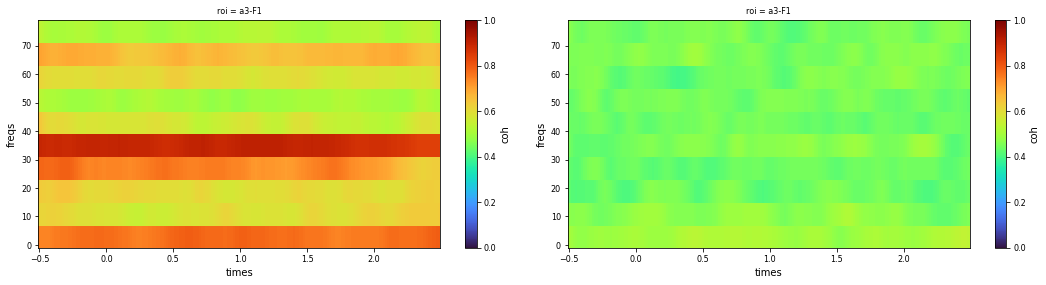

In [14]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
coh.mean("trials").isel(roi=4).sel(times=slice(-0.5,2.5)).plot(x="times", y="freqs", cmap="turbo", vmin=0, vmax=1);
plt.subplot(1,2,2)
coh_surr.mean(dim=("trials","seeds")).sel(times=slice(-0.5,2.5)).isel(roi=4).plot(x="times", y="freqs", cmap="turbo", vmin=0, vmax=1);
plt.tight_layout()

No handles with labels found to put in legend.


(0.0, 80.0)

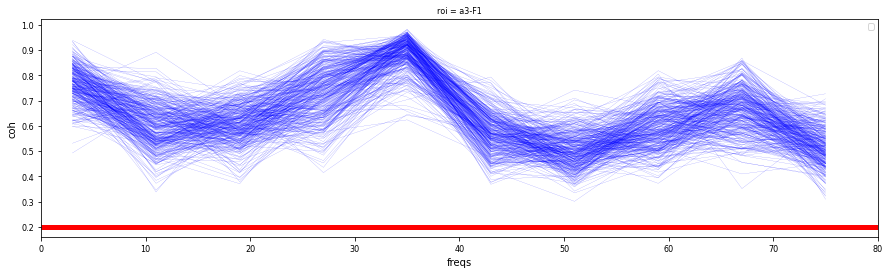

In [15]:
plt.figure(figsize=(15,4))
coh.isel(roi=4).sel(times=slice(-0.5,2.5)).mean("times").plot(x="freqs", hue="trials", lw=.1, color="b");
plt.hlines(0.2, 0, 80, "r", lw=5)
plt.legend();
#coh_surr.isel(roi=4).sel(times=slice(-0.5,2.5)).mean("times").quantile(0.95, "seeds").plot(x="freqs", hue="trials", lw=.1, color="r");
#plt.legend();
plt.xlim(0, 80)

In [16]:
thr = coh_surr.isel(seeds=0).quantile(0.95, "trials")

In [17]:
aux = (coh>=thr)*coh

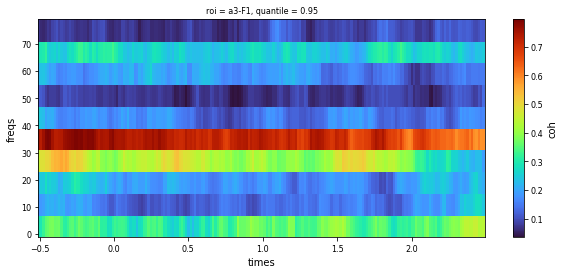

In [18]:
plt.figure(figsize=(10,4))
aux.mean("trials").isel(roi=4).sel(times=slice(-0.5,2.5)).plot(x="times", y="freqs", cmap="turbo");

No handles with labels found to put in legend.


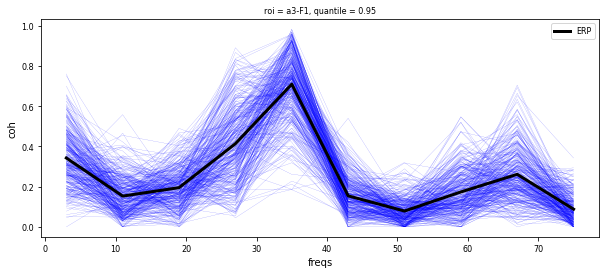

In [19]:
plt.figure(figsize=(10,4))
aux.isel(roi=4).sel(times=slice(-0.5,2.5)).mean("times").plot(x="freqs", hue="trials", lw=.1, color="b");
plt.legend()
aux.isel(roi=4).sel(times=slice(-0.5,2.5)).mean("times").mean("trials").plot(x="freqs", hue="trials", lw=3, color="k", label="ERP");
plt.legend()

In [63]:
coh

<xarray.Dataset>
Dimensions:  (freqs: 5, roi: 4371, times: 244, trials: 595)
Coordinates:
  * trials   (trials) int64 0 1 2 3 4 5 6 7 ... 766 768 769 771 772 773 774 775
  * roi      (roi) object 'a46D-a8B' 'a46D-F6' 'a46D-a9/46D' ... 'V1-V1' 'V1-V1'
  * freqs    (freqs) float64 3.0 10.0 20.0 34.0 61.0
  * times    (times) float64 -0.65 -0.635 -0.62 -0.605 ... 2.95 2.965 2.98 2.995
Data variables:
    coh      (roi, freqs, trials, times) float32 0.80482066 ... 0.2718923

In [2]:
coh = xr.load_dataarray("~/storage1/projects/GrayData-Analysis/Results/lucy/141017/session01/plv_k_0.3_morlet.nc")

In [3]:
thr = xr.load_dataarray("~/storage1/projects/GrayData-Analysis/Results/lucy/141017/session01/plv_k_0.3_morlet_surr.nc")

In [4]:
aux = (coh>=thr)*coh

No handles with labels found to put in legend.


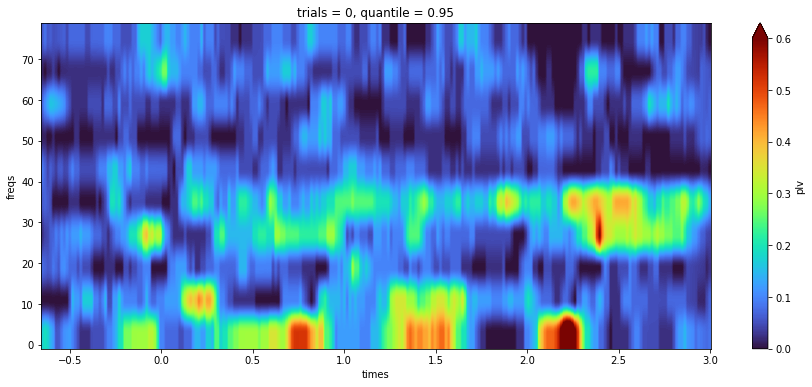

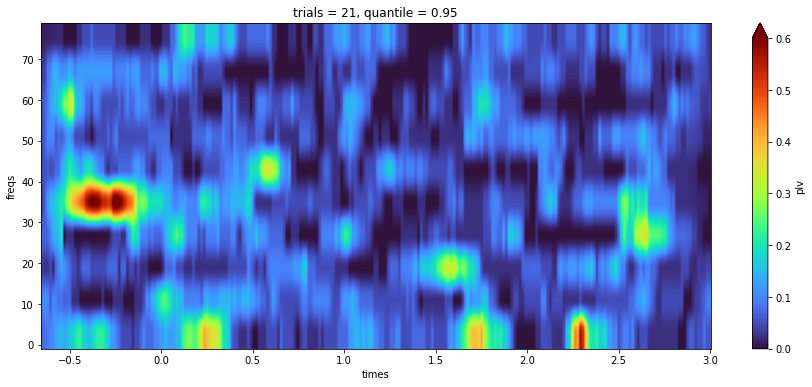

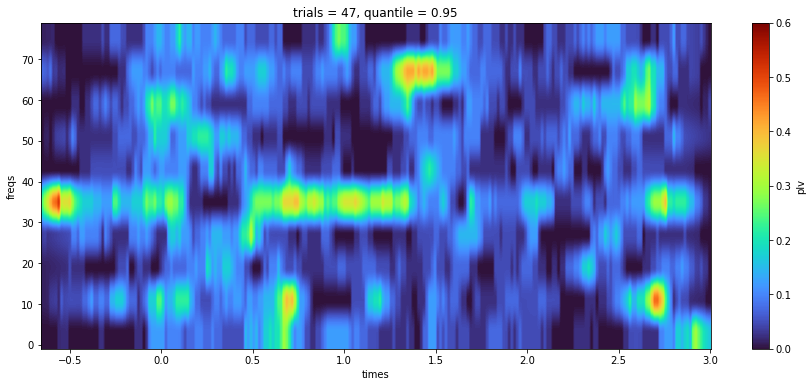

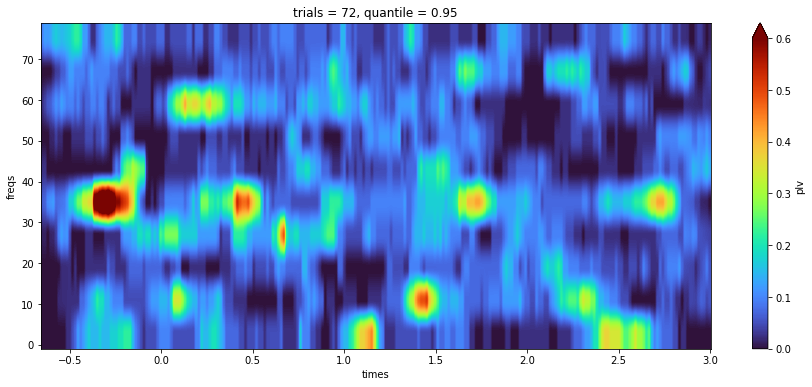

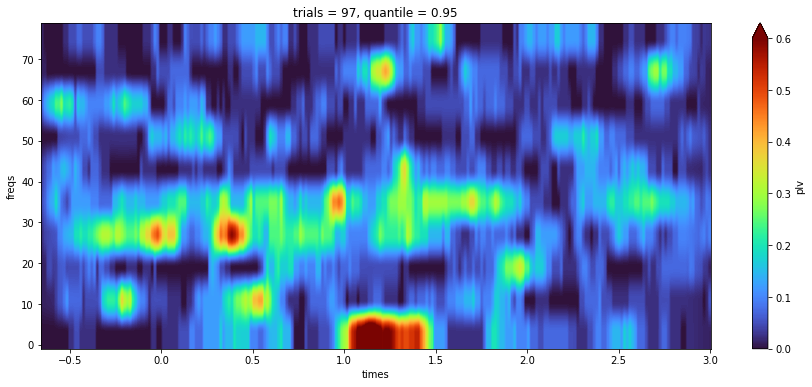

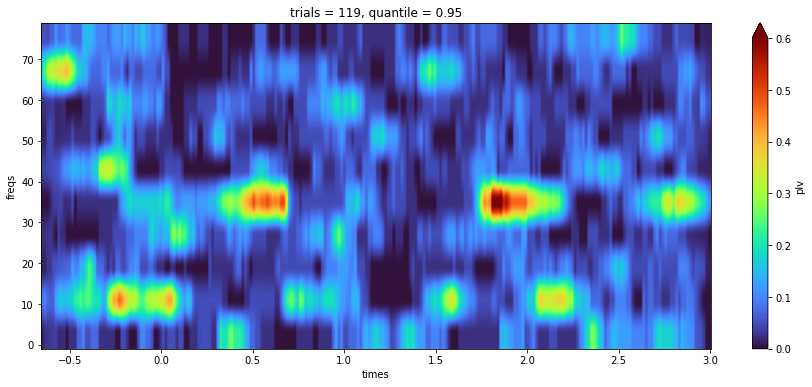

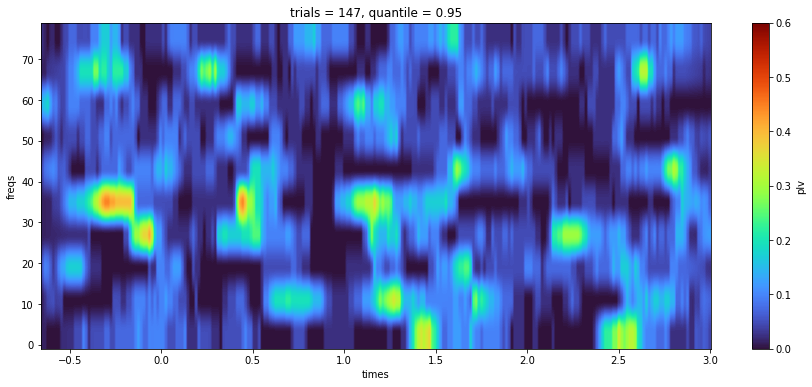

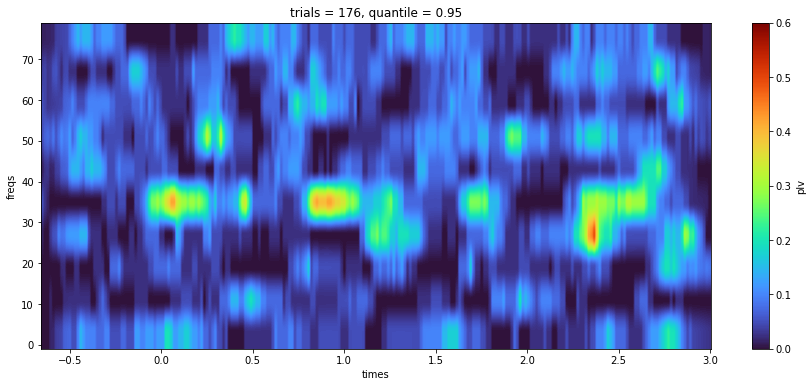

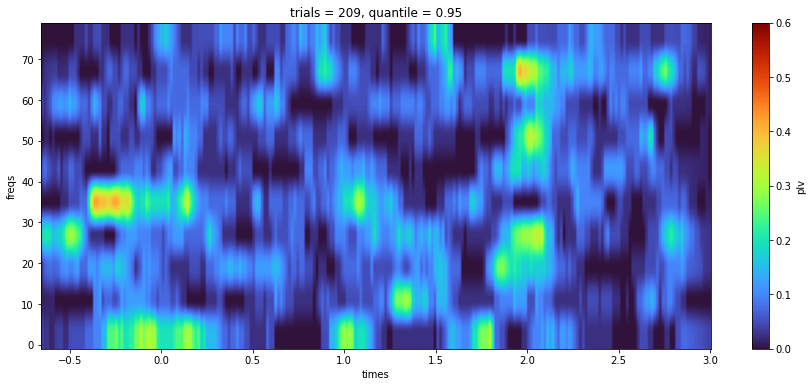

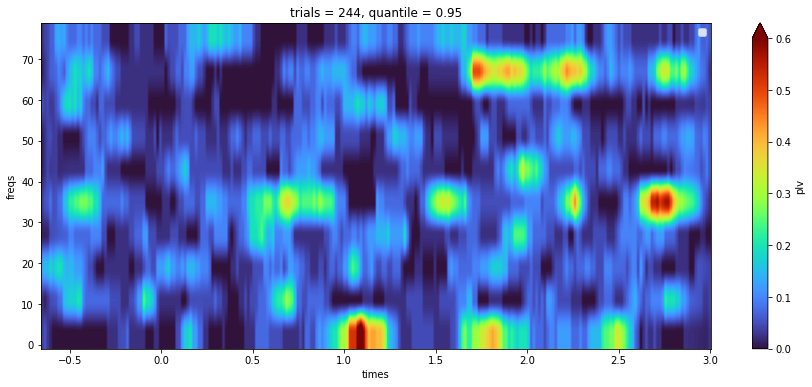

In [5]:
#plt.figure(figsize=(15,6))
for i in range(10):
    plt.figure(figsize=(15,6))
    aux.sel(roi="a3-F1").isel(trials=i*20).mean(dim="roi").plot.imshow(x="times", y="freqs", cmap="turbo", interpolation=None, vmin=0, vmax=.6)
plt.legend()

#### Estimating morlet

In [9]:
x=np.linspace(0,80,1000)
f_c = np.linspace(3, 75,10)
s_f = [2]*len(f_c)

In [10]:
def gauss(mu, std, x):
    return 1/(std*np.sqrt(2*np.pi)) * np.exp(-0.5*( (x-mu)/std )**2)

In [11]:
f=[]
for mu, std in zip(f_c,s_f):
    f+=[gauss(mu, std, x)]

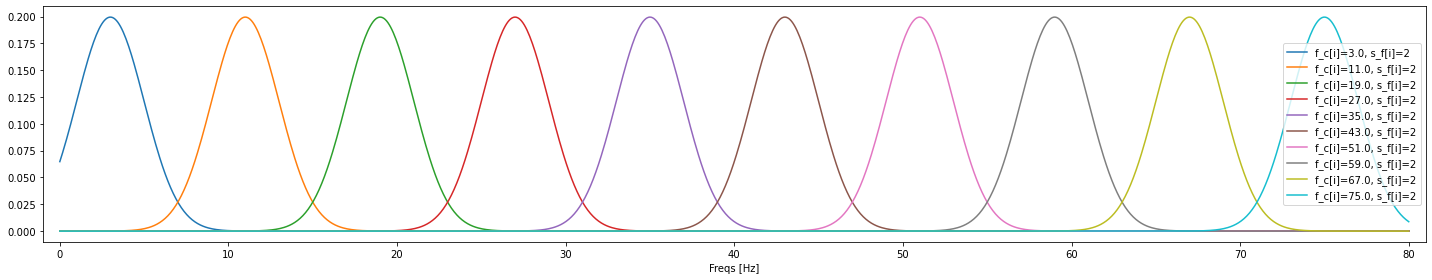

In [12]:
plt.figure(figsize=(20,4))
for i in range(len(f_c)):
    #plt.subplot(1,len(f_c),i+1)
    plt.plot(x, f[i], label=f"{f_c[i]=}, {s_f[i]=}")
    #plt.vlines(foi[i,0], 0,0.3, "k")
    #plt.vlines(foi[i,1], 0,0.3, "k")
    plt.xlim(-1,81)
    plt.legend()
    plt.xlabel("Freqs [Hz]")
plt.tight_layout()

In [2]:
from   GDa.temporal_network import temporal_network

In [3]:
### Methods to read coherence files
def get_coh_file(ks=None, surr=False, mode="morlet"):
    if not surr:
        _COH_FILE = f"coh_k_{ks}_morlet.nc"
    else:
        _COH_FILE = f"coh_k_{ks}_morlet_surr.nc"
    return _COH_FILE

In [4]:
# Parameters to read the data
idx      = 3 
nses     = 1
nmonkey  = 0
align_to = 'cue'

dirs = { 'rawdata':'/home/vinicius/storage1/projects/GrayData-Analysis/GrayLab',
         'results':'Results/',
         'monkey' :['lucy', 'ethyl'],
         'session':'session01',
         'date'   :[['141014', '141015', '141205', '141017','150128', '150211', '150304'], []] }

In [5]:
thr = xr.load_dataarray("~/storage1/projects/GrayData-Analysis/Results/lucy/141017/session01/coh_k_0.3_morlet_surr.nc")

In [8]:
###################################################################################
# Instantiate network to get parameters
###################################################################################

q_thr = None
## Default threshold
kw = dict(q=q_thr)

# Instantiating a temporal network object without thresholding the data
net =  temporal_network(coh_file=get_coh_file(ks=0.3, surr=False, mode="morlet"), monkey=dirs['monkey'][nmonkey], 
                        session=1, date='141017', trial_type=[1], keep_weights=True,
                        behavioral_response=[1], wt=None, drop_trials_after=True,
                        verbose=True, coh_thr=None)

In [ ]:
coh = xr.load_dataarray("~/storage1/projects/GrayData-Analysis/Results/lucy/141017/session01/coh_k_0.3_morlet.nc")

In [6]:
thr

<xarray.DataArray 'coh' (roi: 4371, freqs: 10, times: 244)>
array([[[0.98511321, 0.98063253, 0.97576334, ..., 0.97678266,
         0.97914059, 0.98339282],
        [0.97846758, 0.97243795, 0.96029496, ..., 0.95576465,
         0.9643403 , 0.97359914],
        [0.97667276, 0.96986741, 0.96338891, ..., 0.95288969,
         0.96193625, 0.9689028 ],
        ...,
        [0.98148081, 0.9745147 , 0.96886619, ..., 0.9567972 ,
         0.96511759, 0.97475745],
        [0.97735036, 0.9689938 , 0.95978071, ..., 0.95697966,
         0.96714911, 0.97424943],
        [0.98094701, 0.97525054, 0.96692022, ..., 0.95837415,
         0.96675677, 0.9732799 ]],

       [[0.98314869, 0.97808991, 0.97147463, ..., 0.97423662,
         0.97786286, 0.98274564],
        [0.9838213 , 0.97876936, 0.97205477, ..., 0.95222341,
         0.95924207, 0.96690629],
        [0.97969463, 0.97378163, 0.96726619, ..., 0.95676619,
         0.96419915, 0.97562019],
        ...,
        [0.98049748, 0.97174083, 0.96176157, ..., 0.9539596 ,
         0.96300691, 0.97103758],
        [0.97958937, 0.97639313, 0.97064589, ..., 0.95377387,
         0.96013877, 0.96720658],
        [0.98207039, 0.97820675, 0.97203919, ..., 0.95384004,
         0.96218188, 0.9714806 ]],

       [[0.98349852, 0.98056923, 0.97617848, ..., 0.97588927,
         0.97740498, 0.98237659],
        [0.97859031, 0.97066406, 0.96458936, ..., 0.95668479,
         0.96770706, 0.97526282],
        [0.97917991, 0.97558222, 0.96857312, ..., 0.96473627,
         0.97061462, 0.97310479],
        ...,
        [0.98031314, 0.97475312, 0.96689397, ..., 0.96769598,
         0.97524494, 0.97975288],
        [0.97458938, 0.96494615, 0.95853481, ..., 0.94749257,
         0.95779149, 0.96597696],
        [0.977586  , 0.97206569, 0.96601717, ..., 0.9607586 ,
         0.97097018, 0.97735419]],

       ...,

       [[0.99254353, 0.99030692, 0.9872418 , ..., 0.97708064,
         0.97934986, 0.98260933],
        [0.98163242, 0.97534803, 0.96477522, ..., 0.96156741,
         0.96697223, 0.97339918],
        [0.98549795, 0.98160004, 0.97567379, ..., 0.95409693,
         0.96128052, 0.96806042],
        ...,
        [0.98973034, 0.9862104 , 0.98089684, ..., 0.95539441,
         0.96493744, 0.97145034],
        [0.9883319 , 0.98192089, 0.97489813, ..., 0.96000939,
         0.96966128, 0.97513353],
        [0.98830748, 0.98536246, 0.97960187, ..., 0.95624473,
         0.96355801, 0.97218859]],

       [[0.99241329, 0.98876374, 0.98594499, ..., 0.98192105,
         0.98641356, 0.98901403],
        [0.98266081, 0.97635634, 0.96582649, ..., 0.94579337,
         0.95695837, 0.96606154],
        [0.98711008, 0.9816946 , 0.97414832, ..., 0.96138603,
         0.9692644 , 0.97826112],
        ...,
        [0.99327022, 0.99054198, 0.98762594, ..., 0.94831292,
         0.96176295, 0.96972291],
        [0.99192331, 0.98938602, 0.98675673, ..., 0.95700631,
         0.96452019, 0.97194124],
        [0.98950487, 0.98629737, 0.98240465, ..., 0.96513071,
         0.97156956, 0.97785076]],

       [[0.99248148, 0.99052806, 0.98910667, ..., 0.98214543,
         0.98429742, 0.98622366],
        [0.98209983, 0.97691566, 0.96870827, ..., 0.94714245,
         0.95238826, 0.96032975],
        [0.9890412 , 0.98310191, 0.97846456, ..., 0.95014216,
         0.96022669, 0.96865685],
        ...,
        [0.99295081, 0.99062633, 0.9856833 , ..., 0.9648038 ,
         0.97180981, 0.97519628],
        [0.98868524, 0.98475132, 0.97982333, ..., 0.95543851,
         0.96389364, 0.97267608],
        [0.9908811 , 0.98746389, 0.98364011, ..., 0.95135331,
         0.96327564, 0.97142151]]])
Coordinates:
  * roi       (roi) object 'a46D-a8B' 'a46D-F6' ... 'V1-V1' 'V1-V1'
  * freqs     (freqs) float64 3.0 11.0 19.0 27.0 35.0 43.0 51.0 59.0 67.0 75.0
  * times     (times) float64 -0.65 -0.635 -0.62 -0.605 ... 2.965 2.98 2.995
    quantile  float64 0.95

No handles with labels found to put in legend.


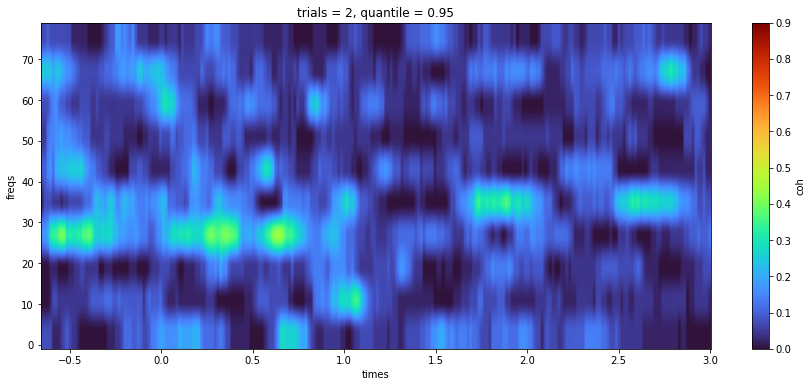

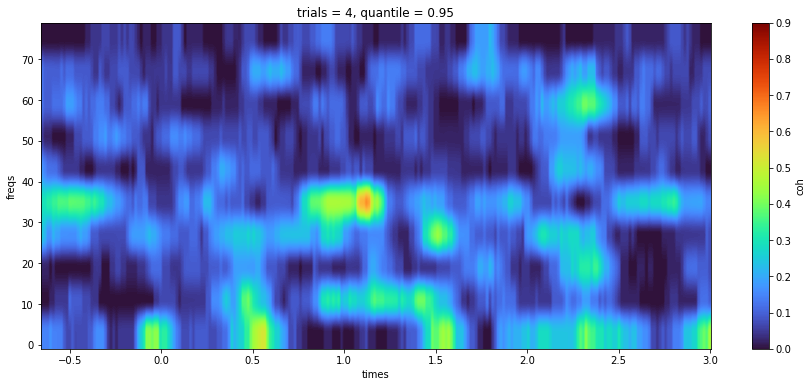

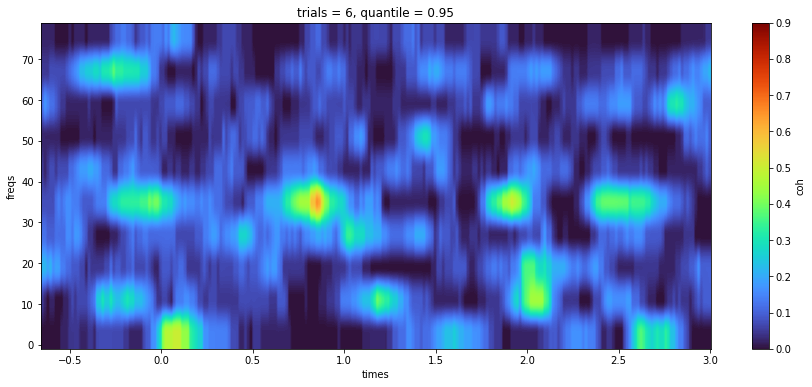

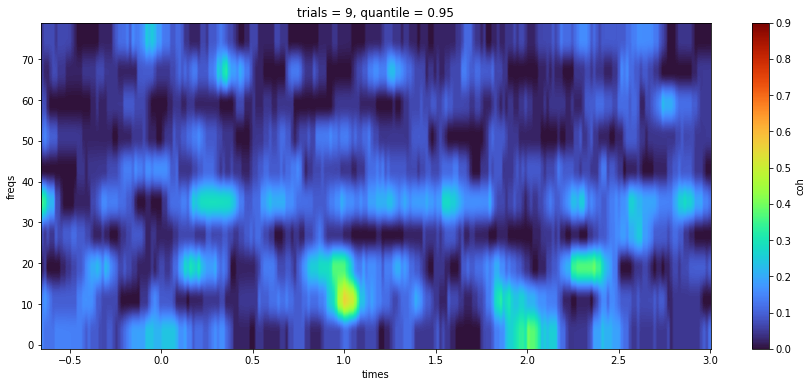

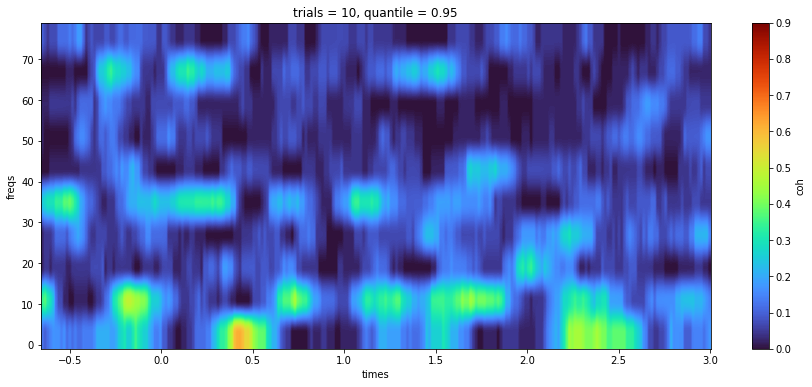

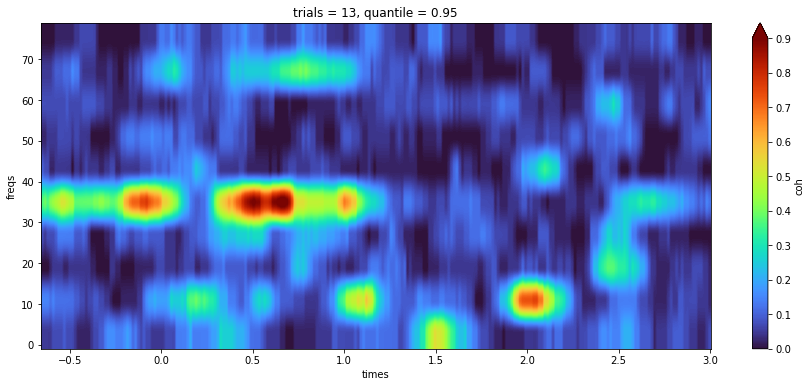

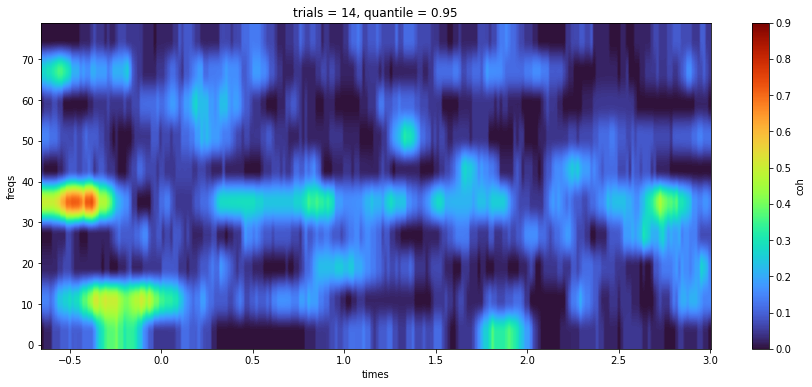

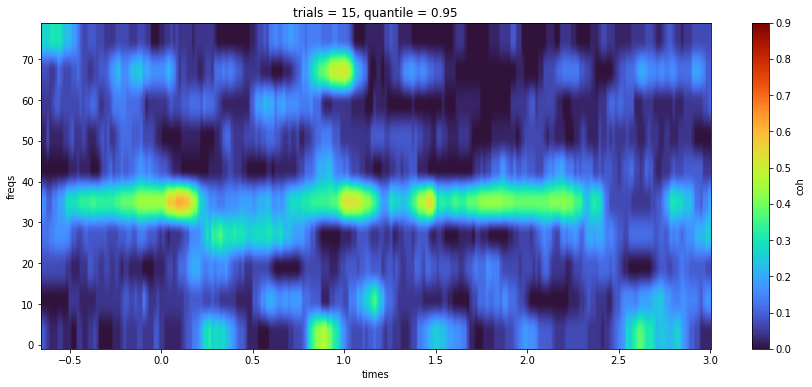

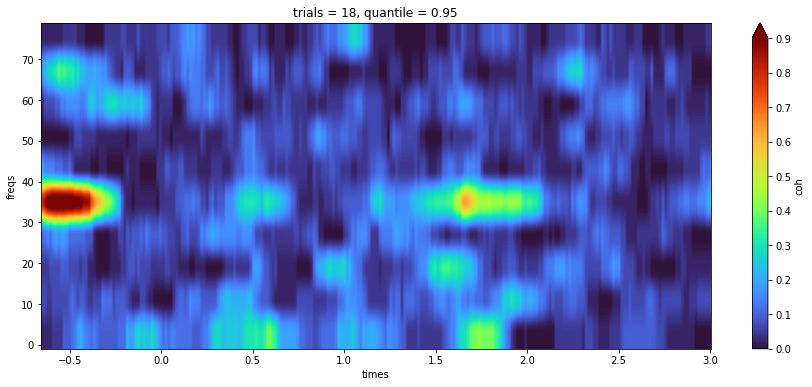

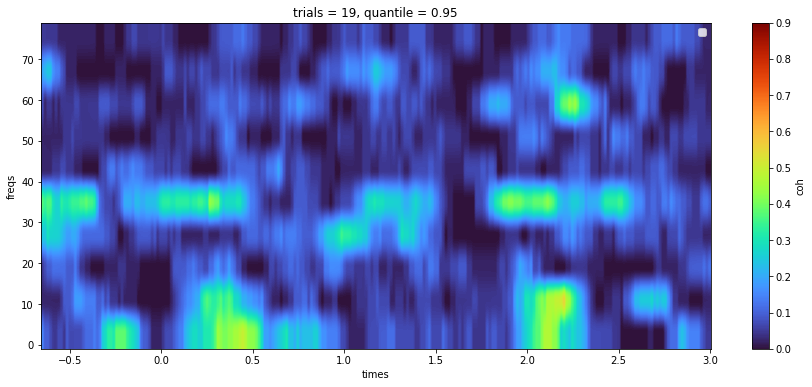

In [15]:
#plt.figure(figsize=(15,6))
for i in range(10):
    plt.figure(figsize=(15,6))
    net.super_tensor.sel(roi="a3-F1").isel(trials=i).mean(dim="roi").plot.imshow(x="times", y="freqs", cmap="turbo", interpolation=None, vmin=0, vmax=.9)
plt.legend()